# Scene Classification using VGG

Steps:
1. Importing (or installing) Tensorflow, Keras and other packages on your system
2. Defining your tensorflow CNN model architecture
3. Loading your data from disk
4. Creating your training and testing splits
5. Data Preprocessing (Augumentation)
6. Compiling your tensorflow CNN model
7. Training your model on your training data
8. Saving The train model
9. Generate Plots for accuracy and validation loss
10. Making predictions using your trained tensorflow model

##### Select GPU Runtime, Install Tensorflow 2.0.0 and restart the runtime

In [ ]:
# !pip install tensorflow-gpu==2.0.0

#### connect Drive folder to colab and set working dir

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Deep Learning Projects/4. Transfer Learning using VGG16")

In [3]:
!dir

Scene\ Classification\ using\ VGG.ipynb  vgg_dataset		   vgg_model_50epochs.model
test_examples				 vgg_dataset.rar
test_examples.rar			 vgg_model_10epochs.model


### Step 1: Importing all the packages

In [4]:
# import the necessary packages  https://justpaste.it/7xo6s
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

Tensorlfow Version:  2.14.0


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("vgg_dataset.rar")
# patoolib.extract_archive("test_examples.rar")

In [5]:
CLASSES = ["buildings", "forest", "sea"]

DATASET = "vgg_dataset"  # this folde must contain three subfolder with images
MODEL = "vgg_16_scene.model" # name to store the model on disk
PLOT = "vgg_plot.png" # plot name

# set the batch size when fine-tuning
BATCH_SIZE = 32

EPOCHS = 10
INIT_LR = 1e-3

# LE_PATH = os.path.sep.join(["output", "le.cpickle"])
# BASE_CSV_PATH = "output"

# # set the path to the serialized model after training
# MODEL_PATH = os.path.sep.join(["output", "scene.model"])

# # define the path to the output training history plots
# UNFROZEN_PLOT_PATH = os.path.sep.join(["output", "unfrozen.png"])
# WARMUP_PLOT_PATH = os.path.sep.join(["output", "warmup.png"])

In [7]:
trainPath = r"vgg_dataset/train"
testPath =  r"vgg_dataset/test"

In [8]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain)
print(totalTest)

1217
559


In [9]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [10]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 1217 images belonging to 3 classes.
Found 559 images belonging to 3 classes.


In [18]:
baseModel = VGG16(weights="imagenet", include_top=True,
                  input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
baseModel.summary()

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
baseModel.summary()

In [27]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4092, activation="relu")(headModel)
headModel = Dense(4092, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
vgg_model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
vgg_model.summary()

In [ ]:
vgg_model.summary()

In [28]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
vgg_model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [30]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = vgg_model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=testGen,
    validation_steps=totalTest // BATCH_SIZE,
    epochs=20)

print("[INFO] serializing network...")
vgg_model.save("vgg_model_20epochs.model", save_format="h5")

[INFO] training head...
Epoch 1/20
38/38 [==============================] - 24s 581ms/step - loss: 4.9192 - accuracy: 0.7595 - val_loss: 0.3484 - val_accuracy: 0.9798
Epoch 2/20
38/38 [==============================] - 23s 613ms/step - loss: 1.6219 - accuracy: 0.9502 - val_loss: 0.1917 - val_accuracy: 0.9890
Epoch 3/20
38/38 [==============================] - 26s 692ms/step - loss: 0.6542 - accuracy: 0.9637 - val_loss: 0.2406 - val_accuracy: 0.9816
Epoch 4/20
38/38 [==============================] - 22s 573ms/step - loss: 0.3801 - accuracy: 0.9713 - val_loss: 0.1345 - val_accuracy: 0.9835
Epoch 5/20
38/38 [==============================] - 24s 636ms/step - loss: 0.2813 - accuracy: 0.9789 - val_loss: 0.1657 - val_accuracy: 0.9871
Epoch 6/20
38/38 [==============================] - 22s 579ms/step - loss: 0.2351 - accuracy: 0.9848 - val_loss: 0.1699 - val_accuracy: 0.9871
Epoch 7/20
38/38 [==============================] - 23s 598ms/step - loss: 0.1663 - accuracy: 0.9840 - val_loss: 0.125

In [39]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
from tensorflow.keras.models import load_model
vgg_model2 = load_model("vgg_model_20epochs.model")

print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = vgg_model2.predict(x=testGen,
    steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating after fine-tuning network head...
18/18 [==============================] - 3s 127ms/step


In [33]:
def plot_acc(H, N, plotPath=None): # https://justpaste.it/6rhbd
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

In [40]:
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))


              precision    recall  f1-score   support

   buildings       0.99      0.99      0.99       190
      forest       0.96      1.00      0.98       182
         sea       1.00      0.97      0.98       187

    accuracy                           0.99       559
   macro avg       0.99      0.99      0.99       559
weighted avg       0.99      0.99      0.99       559



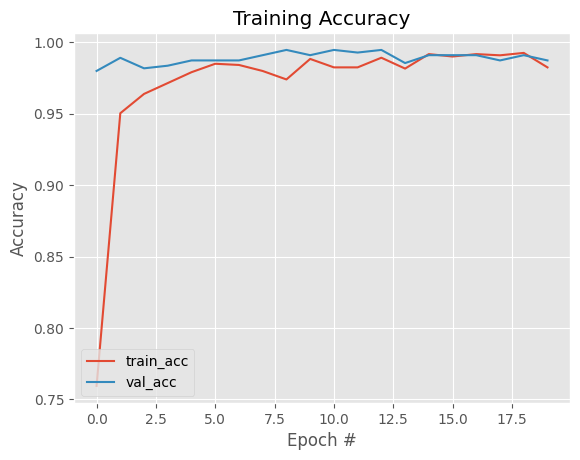

In [41]:
# plot training and val accuracy
plot_acc(H, 20)

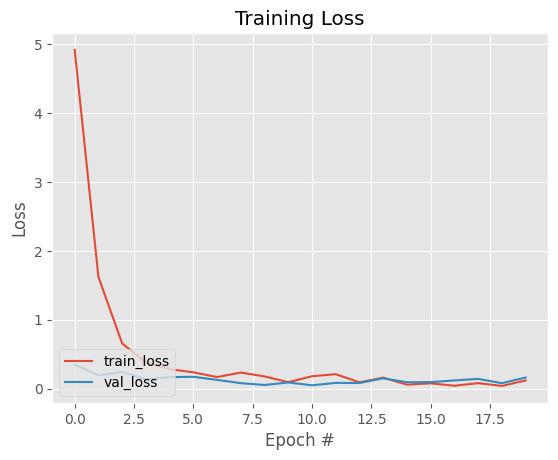

In [42]:
# plot training and val loss
plot_loss(H, 20)

In [ ]:
# # serialize the# serialize the model to disk

# print("[INFO] serializing network...")
# vgg_model2.save("vgg_model_50epochs.model", save_format="h5")

[INFO] serializing network...


## Inference on Unseen Data

In [3]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    # plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [45]:
!dir

acc_output.png				 test_examples.rar	   vgg_model_20epochs.model
loss_output.png				 vgg_dataset		   vgg_model_50epochs.model
Scene\ Classification\ using\ VGG.ipynb  vgg_dataset.rar	   vgg_model_5epochs.model
test_examples				 vgg_model_10epochs.model


In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model
print("[INFO] loading network and...")
model = load_model("vgg_model_20epochs.model")

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        image = cv2.imread(imagePath)
        output = image.copy()
        output = imutils.resize(output, width=400)

        # our model was trained on RGB ordered images but OpenCV represents
        # images in BGR order, so swap the channels, and then resize to
        # 224x224 (the input dimensions for VGG16)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # convert the image to a floating point data type and perform mean
        # subtraction
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean


        # pass the image through the network to obtain our predictions
        preds = model.predict(np.expand_dims(image, axis=0))[0]
        i = np.argmax(preds)
        label = CLASSES[i]

        # draw the prediction on the output image
        text = "{}: {:.2f}%".format(label, preds[i] * 100)
        cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)

         # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


### Deployment

In [ ]:
# build gradio app
!pip install gradio==3.47.1

In [1]:
import os
os.chdir("/content/drive/MyDrive/Deep Learning Projects/4. Transfer Learning using VGG16")

In [4]:
# # load the model
print("[INFO] loading network and...")
model = load_model("vgg_model_20epochs.model")

[INFO] loading network and...


In [5]:
import gradio as gr
print(gr.__version__)

3.47.1


In [6]:
import gradio as gr


def predict_image(image):


    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean

    # pass the image through the network to obtain our predictions
    preds = model.predict(np.expand_dims(image, axis=0))[0]

    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)

    print(result)

    return result



# https://justpaste.it/7xo6s

In [ ]:
# im = gr.Image(type="pil")
# label = gr.Label(num_top_classes=3)
# gr.Interface(fn = predict_image, inputs=im, outputs=label, title="VGG DEMO").launch(share=True,debug=True)

In [7]:
im = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=3)
gr.Interface(fn = predict_image, inputs=im, outputs=label, capture_session=True, title="VGG DEMO").launch(share=True)

<ipython-input-7-3d227d61410a>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  im = gr.inputs.Image(shape=(224,224))
<ipython-input-7-3d227d61410a>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  im = gr.inputs.Image(shape=(224,224))
<ipython-input-7-3d227d61410a>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=3)
<ipython-input-7-3d227d61410a>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=3)
<ipython-input-7-3d227d61410a>:3: GradioDeprecationWarning: `capture_session` parameter is deprecated, and it has no effect
  gr.Interface(fn = predict_image, inputs=im, outputs=label, ca

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3e73b524c0728b0cbe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [11]:
dir(gr)

['Accordion',
 'AnnotatedImage',
 'Annotatedimage',
 'Audio',
 'BarPlot',
 'Blocks',
 'Button',
 'CSVLogger',
 'ChatInterface',
 'Chatbot',
 'Checkbox',
 'CheckboxGroup',
 'Checkboxgroup',
 'ClearButton',
 'Code',
 'ColorPicker',
 'Column',
 'DataFrame',
 'Dataframe',
 'Dataset',
 'Dropdown',
 'DuplicateButton',
 'Error',
 'EventData',
 'Examples',
 'File',
 'FileData',
 'FileExplorer',
 'Files',
 'FlaggingCallback',
 'Gallery',
 'Group',
 'HTML',
 'Highlight',
 'HighlightedText',
 'Highlightedtext',
 'HuggingFaceDatasetSaver',
 'Image',
 'Info',
 'Interface',
 'JSON',
 'Json',
 'Label',
 'LikeData',
 'LinePlot',
 'List',
 'LoginButton',
 'LogoutButton',
 'Markdown',
 'Matrix',
 'Mic',
 'Microphone',
 'Model3D',
 'Number',
 'Numpy',
 'OAuthProfile',
 'PlayableVideo',
 'Plot',
 'Progress',
 'Radio',
 'Request',
 'Row',
 'ScatterPlot',
 'SelectData',
 'SimpleCSVLogger',
 'Slider',
 'State',
 'Tab',
 'TabItem',
 'TabbedInterface',
 'Tabs',
 'Text',
 'TextArea',
 'Textbox',
 'Theme',
 'Upl